In [1]:
import tensorflow_datasets as tfds

# Download the subword encoded pretokenized dataset
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)

# Get the tokenizer
tokenizer = info.features['text'].encoder

2024-01-28 19:41:45.810084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 19:41:45.810238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 19:41:45.828384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 19:41:45.828508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-28 19:41:45.828605: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

# Get the train and test splits
train_data, test_data = dataset['train'], dataset['test'], 

# Shuffle the training data
train_dataset = train_data.shuffle(BUFFER_SIZE)

# Batch and pad the datasets to the maximum length of the sequences
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_data.padded_batch(BATCH_SIZE)

## Build and Compile the Model

You can build multiple layer LSTM models by simply appending another `LSTM` layer in your `Sequential` model and enabling the `return_sequences` flag to `True`. This is because an `LSTM` layer expects a sequence input so if the previous layer is also an LSTM, then it should output a sequence as well. See the code cell below that demonstrates this flag in action. You'll notice that the output dimension is in 3 dimensions `(batch_size, timesteps, features)` when when `return_sequences` is True.

In [8]:
import tensorflow as tf
import numpy as np

# Hypeparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim =8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size, timesteps, features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs =tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output (return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output (return_sequences=True): (1, 20, 8)


In [10]:
import tensorflow as tf

# Hypeparamter
embedding_dim=64
lstm1_dim=64
lstm2_dim=32
dense_dim=64

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size,embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm1_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm2_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          523840    
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 635,329
Trainable params: 635,329
Non-trai

In [11]:
# Set the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
NUM_EPOCHS = 10

# Train the model
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=test_dataset)

Epoch 1/10


2024-01-28 20:08:59.526200: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


98/98 [==============================] - 35s 331ms/step - loss: 0.5606 - accuracy: 0.6950 - val_loss: 0.4488 - val_accuracy: 0.7953
Epoch 2/10
98/98 [==============================] - 32s 325ms/step - loss: 0.3124 - accuracy: 0.8773 - val_loss: 0.3890 - val_accuracy: 0.8565
Epoch 3/10
98/98 [==============================] - 32s 325ms/step - loss: 0.2445 - accuracy: 0.9102 - val_loss: 0.3752 - val_accuracy: 0.8562
Epoch 4/10
98/98 [==============================] - 32s 328ms/step - loss: 0.1772 - accuracy: 0.9378 - val_loss: 0.3946 - val_accuracy: 0.8519
Epoch 5/10
98/98 [==============================] - 32s 330ms/step - loss: 0.1366 - accuracy: 0.9538 - val_loss: 0.4942 - val_accuracy: 0.8459
Epoch 6/10
98/98 [==============================] - 32s 329ms/step - loss: 0.1102 - accuracy: 0.9635 - val_loss: 0.4781 - val_accuracy: 0.8252
Epoch 7/10
98/98 [==============================] - 32s 328ms/step - loss: 0.0969 - accuracy: 0.9686 - val_loss: 0.5998 - val_accuracy: 0.8354
Epoch 8/10

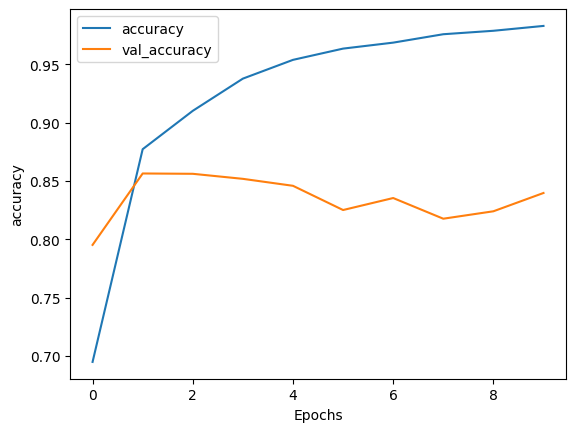

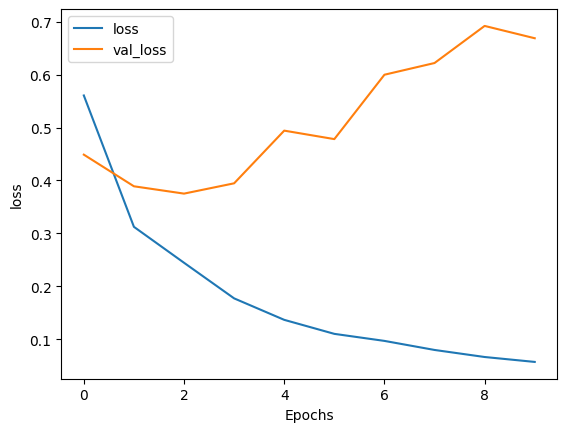

In [13]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results 
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")